In [1]:
import os

from math import log2
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L

def channel_attention(input_tensor, reduction_ratio=16):
    # Global Average Pooling
    channel_avg = L.GlobalAveragePooling2D()(input_tensor)
    channel_avg = L.Dense(input_tensor.shape[-1] // reduction_ratio, activation='relu')(channel_avg)
    channel_avg = L.Dense(input_tensor.shape[-1], activation='sigmoid')(channel_avg)

    # Reshape to original tensor shape
    channel_avg = L.Reshape((1, 1, input_tensor.shape[-1]))(channel_avg)
    return input_tensor * channel_avg


def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x
def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.GroupQueryAttention(head_dim=cf["head_dim"], 
    num_query_heads=cf["num_query_heads"],
    num_key_value_heads=cf["num_key_value_heads"])( x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters):
    x = L.Conv2D(num_filters,  [3, 3], padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters, strides=2):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=strides)(x)
    return x

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape) ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    shape = (
        cf["image_size"]//cf["patch_size"],
        cf["image_size"]//cf["patch_size"],
        cf["hidden_dim"]
    )
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    z9 = L.Reshape(shape)(z9)
    z12 = L.Reshape(shape)(z12)

    ## Additional layers for managing different patch sizes
    total_upscale_factor = int(log2(cf["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2: ## Patch size 16 or greater
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)
        # print(z3.shape, z6.shape, z9.shape, z12.shape)

    if upscale < 0: ## Patch size less than 16
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)

    ## Decoder 1
    x = deconv_block(z12, 128)

    s = deconv_block(z9, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])
    x = channel_attention(x)
    x = conv_block(x, 128)
    x = conv_block(x, 128)
    out1 = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)
    ## Decoder 2
    x = deconv_block(x, 64)

    s = deconv_block(z6, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = channel_attention(x)
    x = conv_block(x, 64)
    x = conv_block(x, 64)
    out2 = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)
    ## Decoder 3
    x = deconv_block(x, 32)

    s = deconv_block(z3, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)

    x = L.Concatenate()([x, s])
    x = channel_attention(x)
    x = conv_block(x, 32)
    x = conv_block(x, 32)
    out3 = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)
    ## Decoder 4
    x = deconv_block(x, 16)

    s = conv_block(z0, 16)
    s = conv_block(s, 16)

    x = L.Concatenate()([x, s])
    x = channel_attention(x)
    x = conv_block(x, 16)
    x = conv_block(x, 16)
    final_output = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid", name="final_output")(x)

    out1 = L.Resizing(256, 256, interpolation="bilinear", name="out1")(out1)
    out2 = L.Resizing(256, 256, interpolation="bilinear", name="out2")(out2)
    out3 = L.Resizing(256, 256, interpolation="bilinear", name="out3")(out3)

    return Model(inputs, [out1, out2, out3, final_output], name="UNETR_2D")


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
def iou(y_true, y_pred, smooth=1e-6):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    y_true_sum = tf.reduce_sum(y_true)
    y_pred_sum = tf.reduce_sum(y_pred)
    union = y_true_sum + y_pred_sum - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
def iou(y_true, y_pred, smooth=1e-6):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    y_true_sum = tf.reduce_sum(y_true)
    y_pred_sum = tf.reduce_sum(y_pred)
    union = y_true_sum + y_pred_sum - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou
from keras.losses import binary_crossentropy, BinaryCrossentropy

def bce_dice_loss(y_true, y_pred):
        loss = binary_crossentropy(y_true, y_pred) + \
               dice_loss(y_true, y_pred)
        return loss / 2.0

In [ ]:
pip install patchify

In [ ]:
import cv2
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from patchify import patchify

""" UNETR  Configration """
cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)
cf["num_query_heads"] = 8  
cf["num_key_value_heads"] = 4  
cf["head_dim"] = cf["hidden_dim"] // cf["num_query_heads"]
def load_dataset(path, split=0.1):
    train_data_path = os.path.join(path, "ISBI2016_ISIC_Part1_Training_Data", "ISBI2016_ISIC_Part1_Training_Data")
    ground_truth_path = os.path.join(path, "ISBI2016_ISIC_Part1_Training_GroundTruth", "ISBI2016_ISIC_Part1_Training_GroundTruth")
    test_data_path = os.path.join(path, "ISBI2016_ISIC_Part1_Test_Data", "ISBI2016_ISIC_Part1_Test_Data")
    test_ground_truth_path = os.path.join(path, "ISBI2016_ISIC_Part1_Test_GroundTruth", "ISBI2016_ISIC_Part1_Test_GroundTruth")

    # Get all training image and mask paths
    train_images = sorted(glob(os.path.join(train_data_path, "*.jpg")))
    train_masks = sorted(glob(os.path.join(ground_truth_path, "*_Segmentation.png")))

    # Get all test image and mask paths
    test_images = sorted(glob(os.path.join(test_data_path, "*.jpg")))
    test_masks = sorted(glob(os.path.join(test_ground_truth_path, "*_Segmentation.png")))
    """ Spliting the data into training and testing """
    split_size = int(len(train_images) * split)
    train_x, valid_x = train_test_split(train_images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(train_masks, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_images, test_masks)

def read_image(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0

    """ Binarize the image """
    # image = np.where(image >= 0.5, 1.0, 0.0)

    """ Processing to patches """
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)

    return patches

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0

    """ Binarize the mask """
    # mask = np.where(mask >= 0.5, 1.0, 0.0)

    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape(cf["flat_patches_shape"])
    y.set_shape([cf["image_size"], cf["image_size"], 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse).batch(batch).prefetch(10)
    return ds

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Hyperparameters """
    batch_size = 8
    lr = 1e-3
    num_epochs = 150

    """ Dataset """
    dataset_path = "/kaggle/input/isic2016/isic"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
    test_dataset  = tf_dataset(test_x, test_y,batch=batch_size)



    def format_multi_outputs(image, mask):
        image = tf.reshape(image, [tf.shape(image)[0], cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"]])
        return image, {
        "out1": mask,
        "out2": mask,
        "out3": mask,
        "final_output": mask,
        }
    train_dataset = train_dataset(format_multi_outputs)
    valid_dataset = valid_dataset.map(format_multi_outputs)
    test_dataset  = test_dataset.map(format_multi_outputs)
    """ Model """
    model= build_unetr_2d(cf)
    losses = {
    "out1": bce_dice_loss,
    "out2": bce_dice_loss,
    "out3": bce_dice_loss,
    "final_output": bce_dice_loss,
    }
    loss_weights = {
    "out1": 0.2,
    "out2": 0.3,
    "out3": 0.5,
    "final_output": 1.0,
    }

    metrics = {
    "out1": [dice_coef, iou],
    "out2": [dice_coef, iou],
    "out3": [dice_coef, iou],
    "final_output": [dice_coef, iou],
    }
    model.compile(optimizer=Adam(lr), loss=losses,
              loss_weights=loss_weights,
              metrics=metrics
              )
    model.summary()

    Unetr_history=model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    ]
    )

In [ ]:
print('\n-------------On Train Set--------------------------\n')
res =model.evaluate(train_dataset, batch_size= 16)
print('________________________')
print('Dice Coef:      | {:.2f} |'.format(res[1]*100))
print('IOU:           | {:.2f} |'.format(res[2] * 100))
print("Loss:           | {:.2f} |".format(res[0]*100))
print('________________________')
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)
print('\n-------------On Validation  Set--------------------------\n')
res = model.evaluate(valid_dataset, batch_size= 16)
print('________________________')
print('Dice Coef:      | {:.2f} |'.format(res[1]*100))
print('IOU:           | {:.2f} |'.format(res[2] * 100))
print("Loss:           | {:.2f} |".format(res[0]*100))
print('________________________')

print('\n-------------On Test  Set--------------------------\n')
res = model.evaluate(test_dataset, batch_size= 16)
print('________________________')
print('Dice Coef:      | {:.2f} |'.format(res[1]*100))
print('IOU:           | {:.2f} |'.format(res[2] * 100))
print("Loss:           | {:.2f} |".format(res[0]*100))
print('________________________')

In [ ]:
from tqdm import tqdm
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    create_dir(f"results")
#     """ Dataset """
#     dataset_path = "Hair-Segmentation"
#     (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: \t{len(train_x)} - {len(train_y)}")
    print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
    print(f"Test: \t{len(test_x)} - {len(test_y)}")

    """ Prediction """
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
        x = image / 255.0

        patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
        patches = patchify(x, patch_shape, cf["patch_size"])
        patches = np.reshape(patches, cf["flat_patches_shape"])
        patches = patches.astype(np.float32)
        patches = np.expand_dims(patches, axis=0)

        """ Read Mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)
        mask = np.concatenate([mask, mask, mask], axis=-1)

        """ Prediction """
        pred = model.predict(patches, verbose=0)[0]
        pred = np.concatenate([pred, pred, pred], axis=-1)
        # pred = (pred > 0.5).astype(np.int32)

        """ Save final mask """
        line = np.ones((cf["image_size"], 10, 3)) * 255
        cat_images = np.concatenate([image, line, mask*255, line, pred*255], axis=1)
        save_image_path = os.path.join("results",  name)
        cv2.imwrite(save_image_path, cat_images)
        """ Save predicted mask separately """
# Create the output directory if it doesn't exist
        pred_mask_dir = "predicted_masks_gqa"
        os.makedirs(pred_mask_dir, exist_ok=True)

# Convert prediction to proper image format (assumes grayscale)
        pred_mask = (pred * 255).astype(np.uint8)
        if  pred_mask.ndim == 3 and pred_mask.shape[2] == 1:
             pred_mask = pred_mask[:, :, 0]  # Squeeze channel if needed

        pred_mask_path = os.path.join(pred_mask_dir, name)
        cv2.imwrite(pred_mask_path, pred_mask)   

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

results_dir = "results"
saved_images = os.listdir(results_dir)
saved_images = [img for img in saved_images if img.endswith(('.png', '.jpg', '.jpeg'))]

# Dice and IoU functions
def dice_coef_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Set up the plotting grid
num_images = len(saved_images)
cols = 3
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(15, 5 * rows))

for i, image_name in enumerate(saved_images):
    image_path = os.path.join(results_dir, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w, _ = image.shape
    section = (w - 20) // 3  # 2 lines of 10 px between 3 images

    original = image[:, :section]
    mask = image[:, section+10:2*section+10]
    pred = image[:, 2*section+20:]

    # Convert to grayscale and normalize
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) / 255.0
    pred_gray = cv2.cvtColor(pred, cv2.COLOR_RGB2GRAY) / 255.0

    # Binarize predictions
    mask_bin = (mask_gray > 0.5).astype(np.float32)
    pred_bin = (pred_gray > 0.5).astype(np.float32)

    dice = dice_coef_np(mask_bin, pred_bin)
    iou = iou_np(mask_bin, pred_bin)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(image)
    plt.title(f"{image_name}\nDice: {dice:.3f}, IoU: {iou:.3f}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np

def iou(outputs: np.array, labels: np.array):
    """Compute Intersection over Union."""
    SMOOTH = 1e-6
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    return ((intersection + SMOOTH) / (union + SMOOTH)).mean()

def dice_coeff(input, target):
    """Compute Dice coefficient."""
    eps = 1e-6
    inter = torch.dot(input.view(-1), target.view(-1))
    union = torch.sum(input) + torch.sum(target) + eps
    return (2 * inter + eps) / union

def eval_seg_single_image(pred_path, gt_path, thresholds=(0.01, 0.1, 0.3, 0.5, 0.7, 0.95)):
    """
    pred_path: path to predicted mask (grayscale image)
    gt_path: path to ground truth mask (grayscale image)
    """
    # Load prediction
    pred = Image.open(pred_path).convert('L')
    pred = transforms.ToTensor()(pred).unsqueeze(0).float()  # shape: [1, 1, H, W]
    pred = pred / pred.max()

    # Load ground truth
    gt = Image.open(gt_path).convert('L')
    gt = transforms.Resize(pred.shape[2:])(gt)  # resize to match pred
    gt = transforms.ToTensor()(gt).unsqueeze(0).float()  # shape: [1, 1, H, W]
    gt = gt / gt.max()

    results = []

    for th in thresholds:
        vpred = (pred > th).float()
        vgt = (gt > th).float()

        vpred_cpu = vpred[:, 0, :, :].cpu().numpy().astype('int32')
        vgt_cpu = vgt[:, 0, :, :].cpu().numpy().astype('int32')

        iou_score = iou(vpred_cpu, vgt_cpu)
        dice_score = dice_coeff(vpred[0, 0], vgt[0, 0]).item()

        results.append((th, iou_score, dice_score))

    # Print results
    print(f"\nEvaluation for {os.path.basename(pred_path)}:")
    for th, iou_val, dice_val in results:
        print(f"  Threshold={th:.2f} | IoU={iou_val:.4f} | Dice={dice_val:.4f}")


In [6]:
eval_seg_single_image(
    pred_path='/kaggle/input/resultsdata/results/predicted_masks_gqa/ISIC_0000222.jpg',
    gt_path='/kaggle/input/isic2016/isic/ISBI2016_ISIC_Part1_Test_GroundTruth/ISBI2016_ISIC_Part1_Test_GroundTruth/ISIC_0000222_Segmentation.png'
)



Evaluation for ISIC_0000222.jpg:
  Threshold=0.01 | IoU=0.6634 | Dice=0.7976
  Threshold=0.10 | IoU=0.7971 | Dice=0.8871
  Threshold=0.30 | IoU=0.8547 | Dice=0.9216
  Threshold=0.50 | IoU=0.8796 | Dice=0.9359
  Threshold=0.70 | IoU=0.9135 | Dice=0.9548
  Threshold=0.95 | IoU=0.9488 | Dice=0.9737


In [7]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

def iou(outputs: np.array, labels: np.array):
    SMOOTH = 1e-6
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    return ((intersection + SMOOTH) / (union + SMOOTH)).mean()

def dice_coeff(input, target):
    eps = 1e-6
    inter = torch.dot(input.view(-1), target.view(-1))
    union = torch.sum(input) + torch.sum(target) + eps
    return (2 * inter + eps) / union

def eval_seg_single_image(pred_path, gt_path, thresholds=(0.01, 0.1, 0.3, 0.5, 0.7, 0.9), visualize=True):
    pred_img = Image.open(pred_path).convert('L')
    gt_img = Image.open(gt_path).convert('L')

    pred_tensor = transforms.ToTensor()(pred_img).unsqueeze(0).float()  # [1, 1, H, W]
    gt_tensor = transforms.Resize(pred_tensor.shape[2:])(gt_img)
    gt_tensor = transforms.ToTensor()(gt_tensor).unsqueeze(0).float()

    pred_tensor = pred_tensor / pred_tensor.max()
    gt_tensor = gt_tensor / gt_tensor.max()

    results = []

    if visualize:
        num_cols = len(thresholds)
        fig, axes = plt.subplots(3, num_cols, figsize=(4*num_cols, 10))

    for i, th in enumerate(thresholds):
        vpred = (pred_tensor > th).float()
        vgt = (gt_tensor > th).float()

        vpred_np = vpred[0, 0].cpu().numpy()
        vgt_np = vgt[0, 0].cpu().numpy()

        iou_score = iou(vpred_np.astype('int32')[None, ...], vgt_np.astype('int32')[None, ...])
        dice_score = dice_coeff(vpred[0, 0], vgt[0, 0]).item()
        results.append((th, iou_score, dice_score))

        if visualize:
            axes[0, i].imshow(pred_img, cmap='gray')
            axes[0, i].set_title(f'Pred @ th={th:.2f}')
            axes[0, i].axis('off')

            axes[1, i].imshow(gt_tensor[0, 0].cpu().numpy(), cmap='gray')
            axes[1, i].set_title('GT')
            axes[1, i].axis('off')

            overlay = np.zeros((*vgt_np.shape, 3))
            overlay[vgt_np == 1] = [0, 1, 0]  # GT - green
            overlay[vpred_np == 1] = [1, 0, 0]  # Pred - red
            overlay[(vgt_np == 1) & (vpred_np == 1)] = [1, 1, 0]  # Intersection - yellow

            axes[2, i].imshow(overlay)
            axes[2, i].set_title(f'Overlay\nIoU={iou_score:.2f}, Dice={dice_score:.2f}')
            axes[2, i].axis('off')

    if visualize:
        num_cols = len(thresholds)
        fig, axes = plt.subplots(1, num_cols, figsize=(4 * num_cols, 4))

    for i, th in enumerate(thresholds):
        vpred = (pred_tensor > th).float()
        vgt = (gt_tensor > th).float()

        vpred_np = vpred[0, 0].cpu().numpy()
        vgt_np = vgt[0, 0].cpu().numpy()

        iou_score = iou(vpred_np.astype('int32')[None, ...], vgt_np.astype('int32')[None, ...])
        dice_score = dice_coeff(vpred[0, 0], vgt[0, 0]).item()
        results.append((th, iou_score, dice_score))

        if visualize:
            axes[i].imshow(vpred_np, cmap='gray')  # White predicted mask on black background
            axes[i].set_title(f'th={th:.2f}\nIoU={iou_score:.2f}, Dice={dice_score:.2f}')
            axes[i].axis('off')


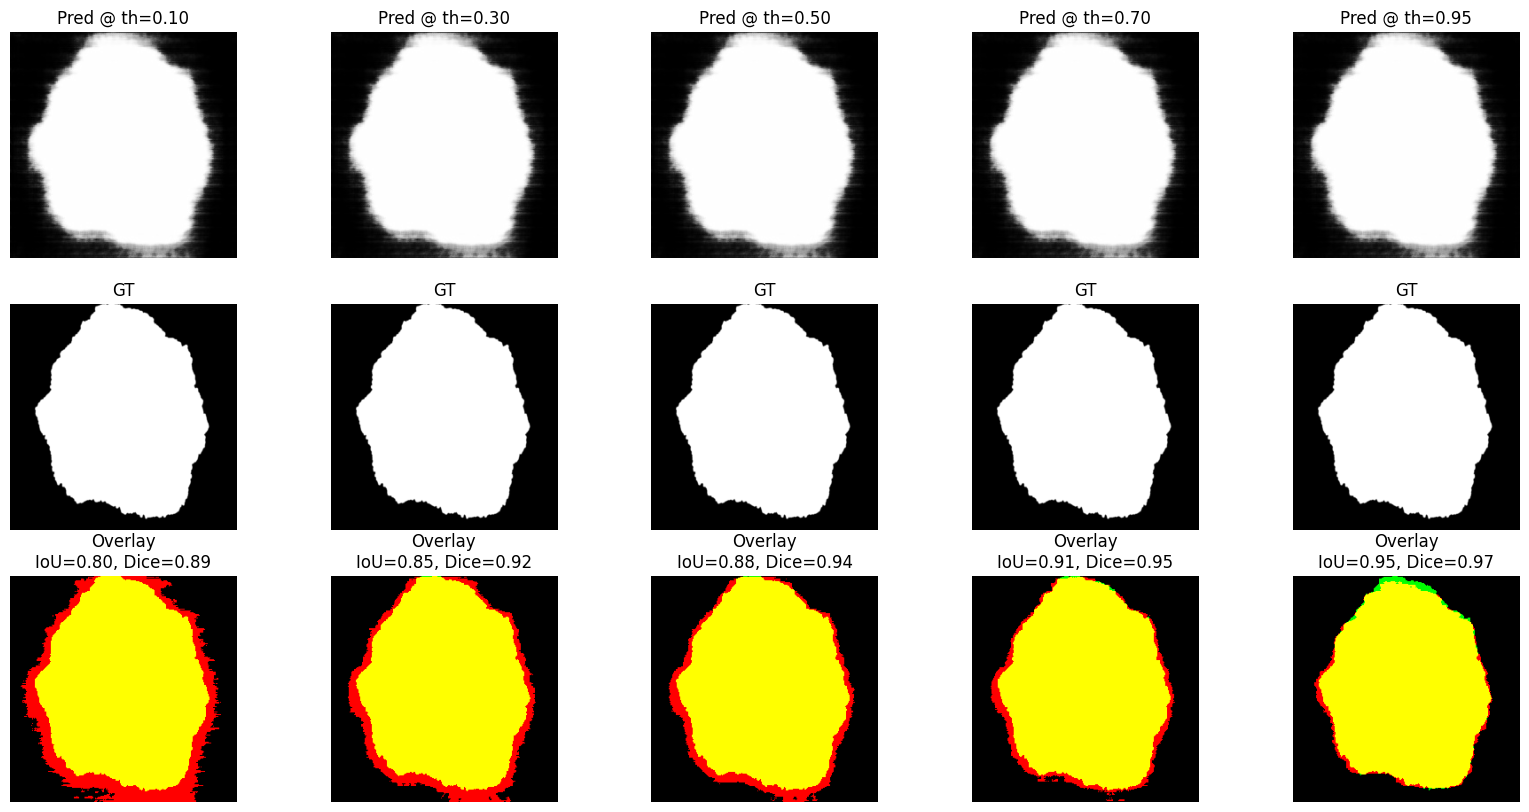

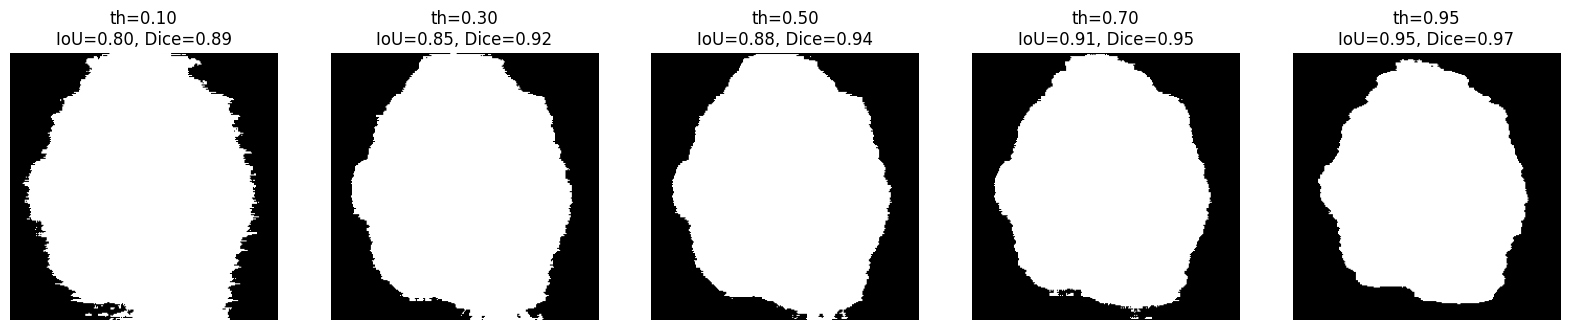

In [19]:
eval_seg_single_image(
    pred_path='/kaggle/input/resultsdata/results/predicted_masks_gqa/ISIC_0000222.jpg',
    gt_path='/kaggle/input/isic2016/isic/ISBI2016_ISIC_Part1_Test_GroundTruth/ISBI2016_ISIC_Part1_Test_GroundTruth/ISIC_0000222_Segmentation.png',
    thresholds=(0.1, 0.3, 0.5, 0.7, 0.95),
    visualize=True
)


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import cv2

def visualize_with_boundaries_and_brown_fill(orig_img_path, pred_mask_path, gt_mask_path, threshold=0.5):
    """
    Overlays predicted and ground truth masks on the original image.
    Blue boundary for predicted mask, Red boundary for ground truth mask, and Brown fill inside predicted mask.

    Args:
        orig_img_path (str): Path to original input image (RGB).
        pred_mask_path (str): Path to predicted mask (grayscale).
        gt_mask_path (str): Path to ground truth mask (grayscale).
        threshold (float): Threshold for binarizing the prediction and ground truth masks.
    """
    # Load images
    orig_img = Image.open(orig_img_path).convert('RGB')
    pred_mask = Image.open(pred_mask_path).convert('L')
    gt_mask = Image.open(gt_mask_path).convert('L')

    transform = transforms.Resize((256, 256))
    orig_img = transform(orig_img)
    pred_mask = transform(pred_mask)
    gt_mask = transform(gt_mask)

    # Convert to arrays
    orig_np = np.array(orig_img).astype(np.uint8)
    pred_np = np.array(pred_mask).astype(np.float32) / 255.0
    gt_np = np.array(gt_mask).astype(np.float32) / 255.0

    # Binarize masks
    pred_bin = (pred_np > threshold).astype(np.uint8)
    gt_bin = (gt_np > threshold).astype(np.uint8)

    # Find edges using the Canny edge detector
    pred_edges = cv2.Canny(pred_bin.astype(np.uint8)*255, 100, 200)
    gt_edges = cv2.Canny(gt_bin.astype(np.uint8)*255, 100, 200)
    # Dilate for visibility
    kernel = np.ones((2,2), np.uint8)
    pred_edges = cv2.dilate(pred_edges, kernel, iterations=1)
    gt_edges = cv2.dilate(gt_edges, kernel, iterations=1)
    # Create color overlays for the boundaries
    overlay = orig_np.copy()

    # Brown color fill inside the predicted mask (semi-transparent)
    # brown_fill = np.array([139, 69, 19])  # Brown color (RGB: 139, 69, 19)
    # brown_area = (pred_bin == 1)  # Where predicted mask is 1 (foreground)

    # # Apply brown fill using alpha blending (transparency effect)
    # alpha = 0.6  # transparency level (adjust as needed)
    # overlay[brown_area] = (alpha * brown_fill + (1 - alpha) * overlay[brown_area]).astype(np.uint8)

    # Blue for predicted boundaries (only where edges are detected)
    overlay[pred_edges == 255] = [0, 0, 255]  # Blue boundary

    # Red for ground truth boundaries (only where edges are detected)
    overlay[gt_edges == 255] = [255, 0, 0]  # Red boundary

    # Display the result
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"Prediction (Brown Fill & Blue Boundaries) vs Ground Truth (Red Boundaries)")
    plt.show()



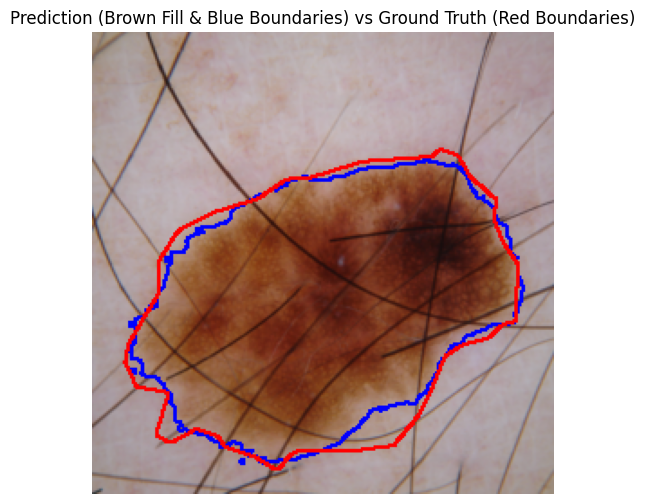

In [45]:
visualize_with_boundaries_and_brown_fill(
    orig_img_path="/kaggle/input/isic2016/isic/ISBI2016_ISIC_Part1_Test_Data/ISBI2016_ISIC_Part1_Test_Data/ISIC_0000380.jpg",    # Original Image
    pred_mask_path="/kaggle/input/resultsdata/results/predicted_masks_gqa/ISIC_0000380.jpg",  # Predicted Mask
    gt_mask_path="/kaggle/input/isic2016/isic/ISBI2016_ISIC_Part1_Test_GroundTruth/ISBI2016_ISIC_Part1_Test_GroundTruth/ISIC_0000380_Segmentation.png",  # Ground Truth Mask
    threshold=0.98
)


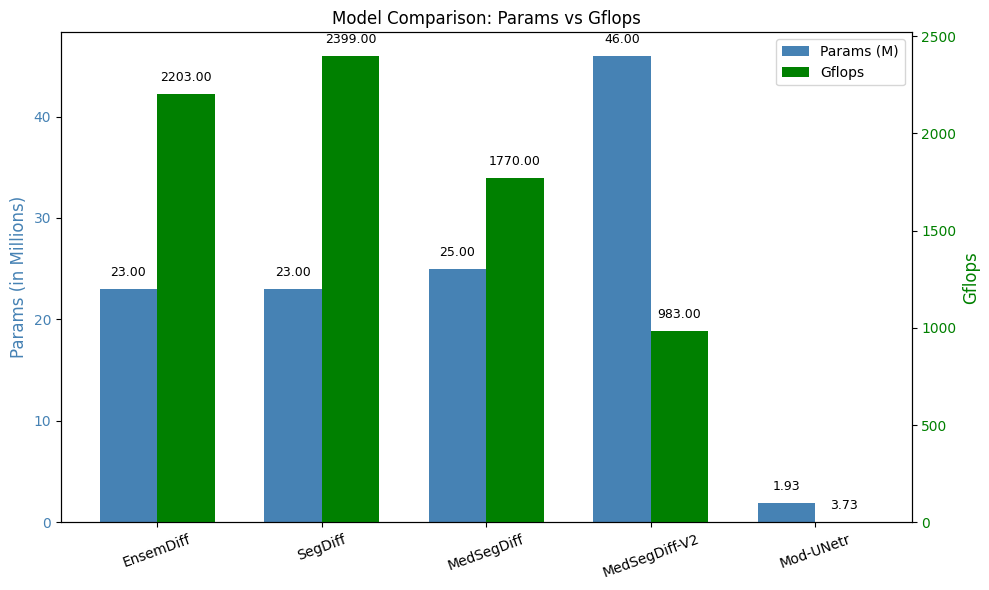

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = ['EnsemDiff', 'SegDiff', 'MedSegDiff', 'MedSegDiff-V2', 'Mod-UNetr']
params = [23, 23, 25, 46, 1.93]
gflops = [2203, 2399, 1770, 983, 3.73]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Params on primary y-axis
bars1 = ax1.bar(x - width/2, params, width, label='Params (M)', color='steelblue')
ax1.set_ylabel('Params (in Millions)', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=20)
ax1.set_title('Model Comparison: Params vs Gflops')

# Annotate Params
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

# Plot Gflops on secondary y-axis
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, gflops, width, label='Gflops', color='green')
ax2.set_ylabel('Gflops', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Annotate Gflops
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

# Legend
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()


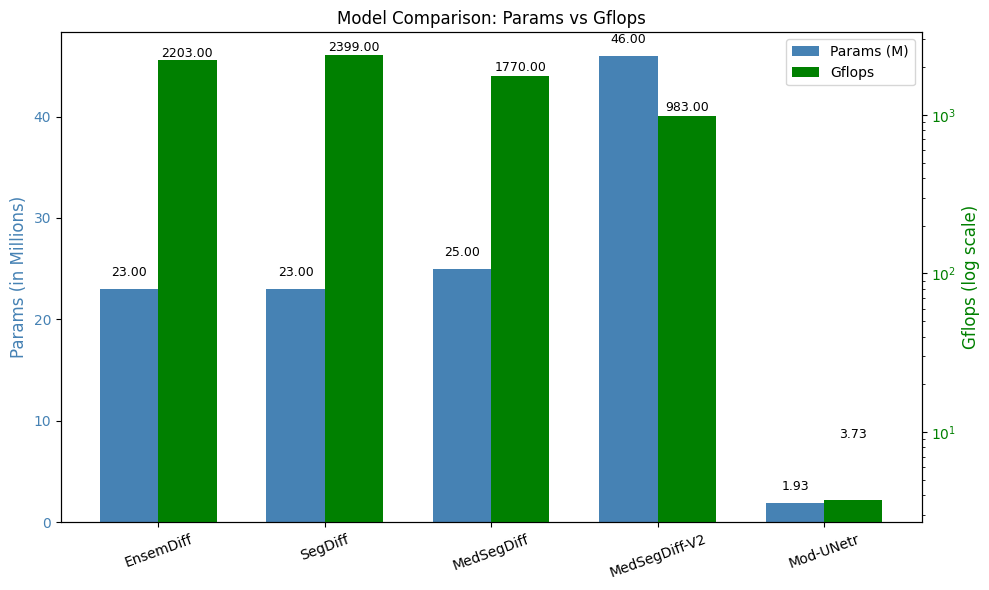

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = ['EnsemDiff', 'SegDiff', 'MedSegDiff', 'MedSegDiff-V2', 'Mod-UNetr']
params = [23, 23, 25, 46, 1.93]
gflops = [2203, 2399, 1770, 983, 3.73]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Params on primary y-axis
bars1 = ax1.bar(x - width/2, params, width, label='Params (M)', color='steelblue')
ax1.set_ylabel('Params (in Millions)', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=20)
ax1.set_title('Model Comparison: Params vs Gflops')

# Annotate Params
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

# Plot Gflops on secondary y-axis (log scale)
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, gflops, width, label='Gflops', color='green')
ax2.set_yscale('log')
ax2.set_ylabel('Gflops (log scale)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Annotate Gflops
for bar, val in zip(bars2, gflops):
    offset = 30 if val > 100 else 5
    ax2.text(bar.get_x() + bar.get_width()/2, val + offset, f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# Legend
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()


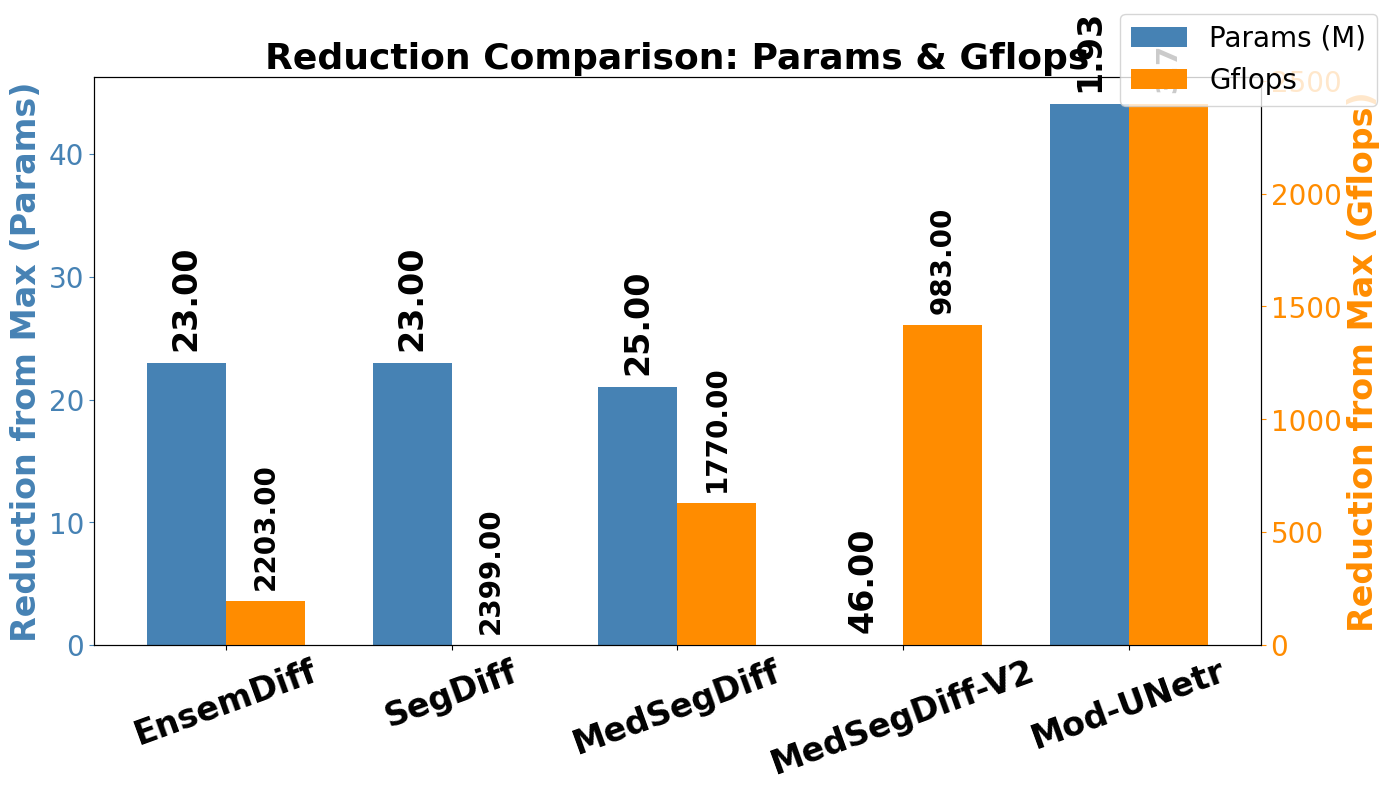

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = ['EnsemDiff', 'SegDiff', 'MedSegDiff', 'MedSegDiff-V2', 'Mod-UNetr']
params = [23, 23, 25, 46, 1.93]
gflops = [2203, 2399, 1770, 983, 3.73]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 8))

# Inverted Params Bar Chart (to show reduction visually)
bars1 = ax1.bar(x - width/2, [max(params) - p for p in params], width, 
                label='Params Reduction', color='steelblue')

# Show actual param values on top of bars
for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{params[i]:.2f}', ha='center', va='bottom', fontsize=24, fontweight='bold', rotation=90)

# Twin axis for Gflops
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, [max(gflops) - g for g in gflops], width, 
                label='Gflops Reduction', color='darkorange')

# Show actual gflops values on top of bars
for i, bar in enumerate(bars2):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{gflops[i]:.2f}', ha='center', va='bottom', fontsize=20, fontweight='bold', rotation=90)

# Axis settings
ax1.set_ylabel('Reduction from Max (Params)', fontsize=24, fontweight='bold', color='steelblue')
ax2.set_ylabel('Reduction from Max (Gflops)', fontsize=24, fontweight='bold', color='darkorange')
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=24, fontweight='bold', rotation=20)
ax1.set_title('Reduction Comparison: Params & Gflops', fontsize=26, fontweight='bold')
ax1.tick_params(axis='y', labelsize=20, colors='steelblue')
ax2.tick_params(axis='y', labelsize=20, colors='darkorange')

# Legend
fig.legend(['Params (M)', 'Gflops'], loc='upper right', fontsize=20)

plt.tight_layout()
plt.show()


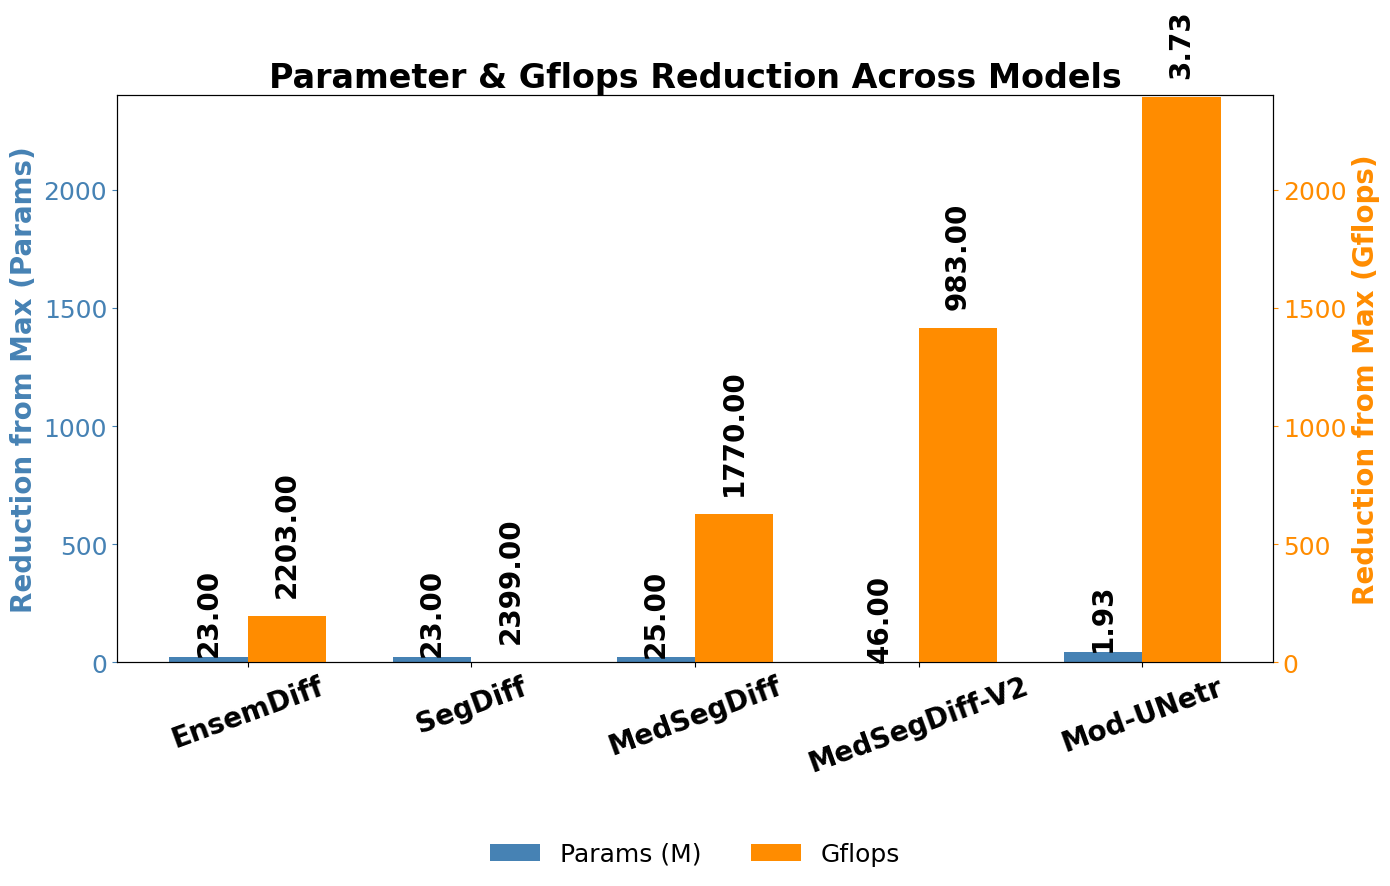

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['EnsemDiff', 'SegDiff', 'MedSegDiff', 'MedSegDiff-V2', 'Mod-UNetr']
params = [23, 23, 25, 46, 1.93]
gflops = [2203, 2399, 1770, 983, 3.73]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 8))

# Inverted Params Bar Chart (to show reduction visually)
bars1 = ax1.bar(x - width/2, [max(params) - p for p in params], width, 
                label='Params (M)', color='steelblue')

# Show actual param values on top of bars
for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{params[i]:.2f}', ha='center', va='bottom', fontsize=20, fontweight='bold', rotation=90)

# Inverted Gflops Bar Chart
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, [max(gflops) - g for g in gflops], width, 
                label='Gflops', color='darkorange')

# Show actual Gflops values
for i, bar in enumerate(bars2):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 80,
             f'{gflops[i]:.2f}', ha='center', va='bottom', fontsize=20, fontweight='bold', rotation=90)

# Axis Settings
ax1.set_ylabel('Reduction from Max (Params)', fontsize=20, fontweight='bold', color='steelblue')
ax1.set_ylim(0, max([max(params) - min(params), max(gflops) - min(gflops)]) + 5)
ax1.tick_params(axis='y', labelsize=18, colors='steelblue')

ax2.set_ylabel('Reduction from Max (Gflops)', fontsize=20, fontweight='bold', color='darkorange')
ax2.set_ylim(0, max([max(params) - min(params), max(gflops) - min(gflops)]) + 5)
ax2.tick_params(axis='y', labelsize=18, colors='darkorange')

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=20, fontweight='bold', rotation=20)

# Title
ax1.set_title('Parameter & Gflops Reduction Across Models', fontsize=24, fontweight='bold')

# Cleaned-up Legend (placed below)
fig.legend(['Params (M)', 'Gflops'], loc='lower center', bbox_to_anchor=(0.5, -0.12), 
           fontsize=18, ncol=2, frameon=False)

plt.tight_layout()
plt.show()


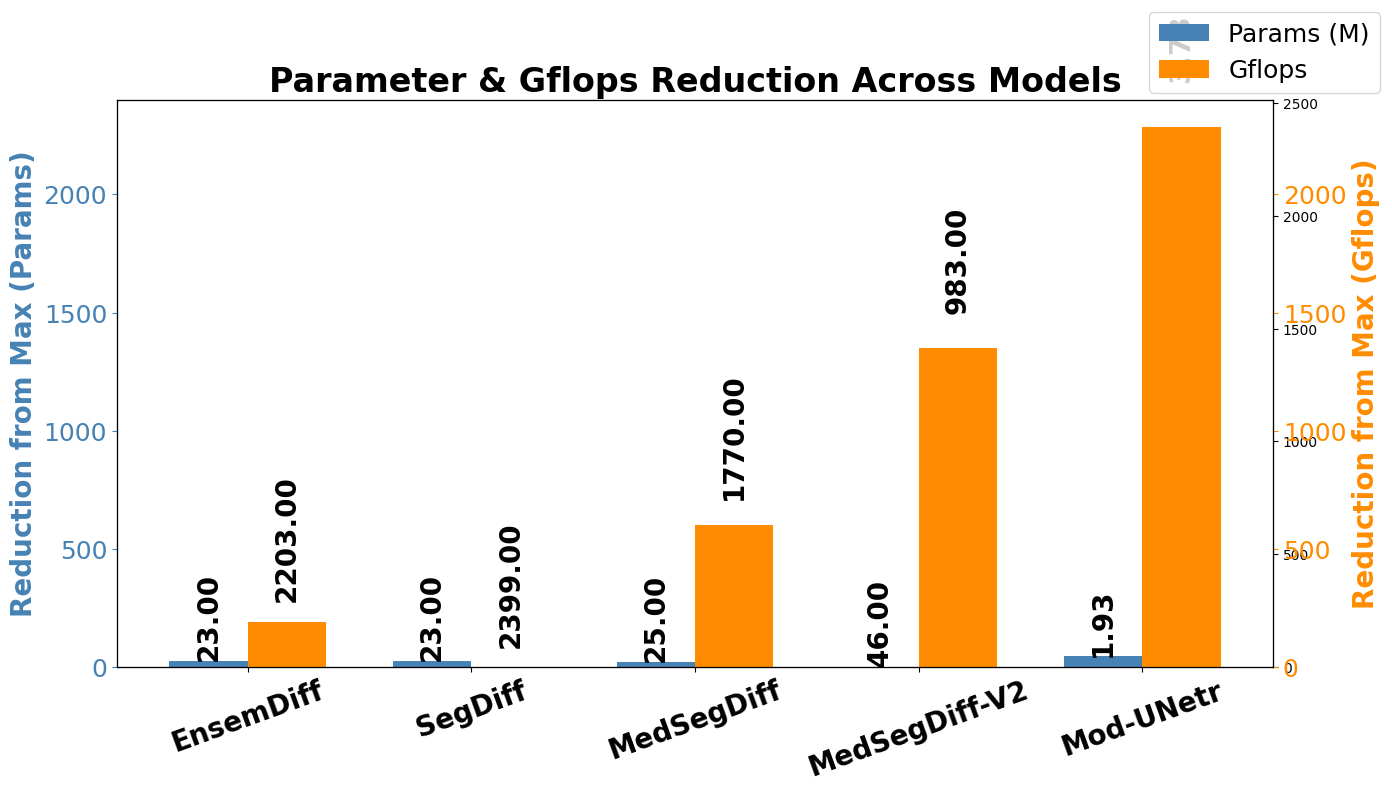

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['EnsemDiff', 'SegDiff', 'MedSegDiff', 'MedSegDiff-V2', 'Mod-UNetr']
params = [23, 23, 25, 46, 1.93]
gflops = [2203, 2399, 1770, 983, 3.73]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar for Params (inverted to show reduction)
bars1 = ax1.bar(x - width/2, [max(params) - p for p in params], width, 
                label='Params (M)', color='steelblue')

# Annotate Params
for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{params[i]:.2f}', ha='center', va='bottom', fontsize=20, fontweight='bold', rotation=90)

# Bar for Gflops (inverted)
bars2 = ax1.twinx().bar(x + width/2, [max(gflops) - g for g in gflops], width, 
                        label='Gflops', color='darkorange')

# Annotate Gflops
for i, bar in enumerate(bars2):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 80,
             f'{gflops[i]:.2f}', ha='center', va='bottom', fontsize=20, fontweight='bold', rotation=90)

# Axis Settings
ax1.set_ylabel('Reduction from Max (Params)', fontsize=20, fontweight='bold', color='steelblue')
ax1.set_ylim(0, max([max(params) - min(params), max(gflops) - min(gflops)]) + 5)
ax1.tick_params(axis='y', labelsize=18, colors='steelblue')

ax2 = ax1.twinx()
ax2.set_ylabel('Reduction from Max (Gflops)', fontsize=20, fontweight='bold', color='darkorange')
ax2.set_ylim(0, max([max(params) - min(params), max(gflops) - min(gflops)]) + 5)
ax2.tick_params(axis='y', labelsize=18, colors='darkorange')

# X-axis
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=20, fontweight='bold', rotation=20)

# Title
ax1.set_title('Parameter & Gflops Reduction Across Models', fontsize=24, fontweight='bold')

# Legend
fig.legend(['Params (M)', 'Gflops'], loc='upper right', fontsize=18)

plt.tight_layout()
plt.show()


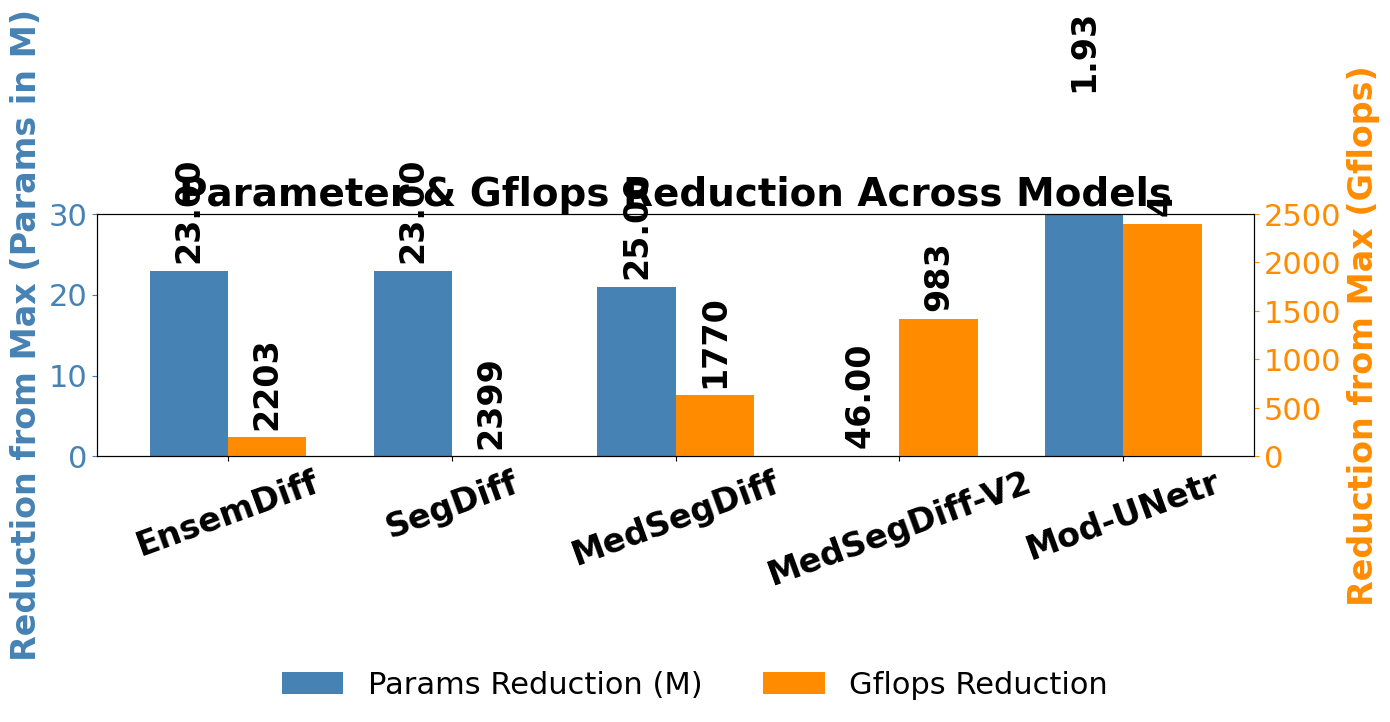

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['EnsemDiff', 'SegDiff', 'MedSegDiff', 'MedSegDiff-V2', 'Mod-UNetr']
params = [23, 23, 25, 46, 1.93]
gflops = [2203, 2399, 1770, 983, 3.73]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 8))

# Params Reduction (max - params)
param_reduction = [max(params) - p for p in params]
bars1 = ax1.bar(x - width/2, param_reduction, width, label='Params Reduction (M)', color='steelblue')

# Show actual param values on top of bars, rotated 90°
for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{params[i]:.2f}', ha='center', va='bottom', fontsize=24, fontweight='bold', rotation=90)

# Gflops Reduction (max - gflops)
gflops_reduction = [max(gflops) - g for g in gflops]
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, gflops_reduction, width, label='Gflops Reduction', color='darkorange')

# Show actual gflops values on top, rotated 90°
for i, bar in enumerate(bars2):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 80,
             f'{gflops[i]:.0f}', ha='center', va='bottom', fontsize=24, fontweight='bold', rotation=90)

# Set y-axis limits and ticks explicitly
ax1.set_ylim(0, 30)
ax1.set_yticks([0, 10, 20, 30])
ax1.set_ylabel('Reduction from Max (Params in M)', fontsize=24, fontweight='bold', color='steelblue')
ax1.tick_params(axis='y', labelsize=22, colors='steelblue')

ax2.set_ylim(0, 2500)
ax2.set_yticks([0, 500, 1000, 1500, 2000, 2500])
ax2.set_ylabel('Reduction from Max (Gflops)', fontsize=24, fontweight='bold', color='darkorange')
ax2.tick_params(axis='y', labelsize=22, colors='darkorange')

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=24, fontweight='bold', rotation=20)

# Title
ax1.set_title('Parameter & Gflops Reduction Across Models', fontsize=28, fontweight='bold')

# Legend below
fig.legend(['Params Reduction (M)', 'Gflops Reduction'], loc='lower center', bbox_to_anchor=(0.5, -0.15),
           fontsize=22, ncol=2, frameon=False)

plt.tight_layout()
plt.show()


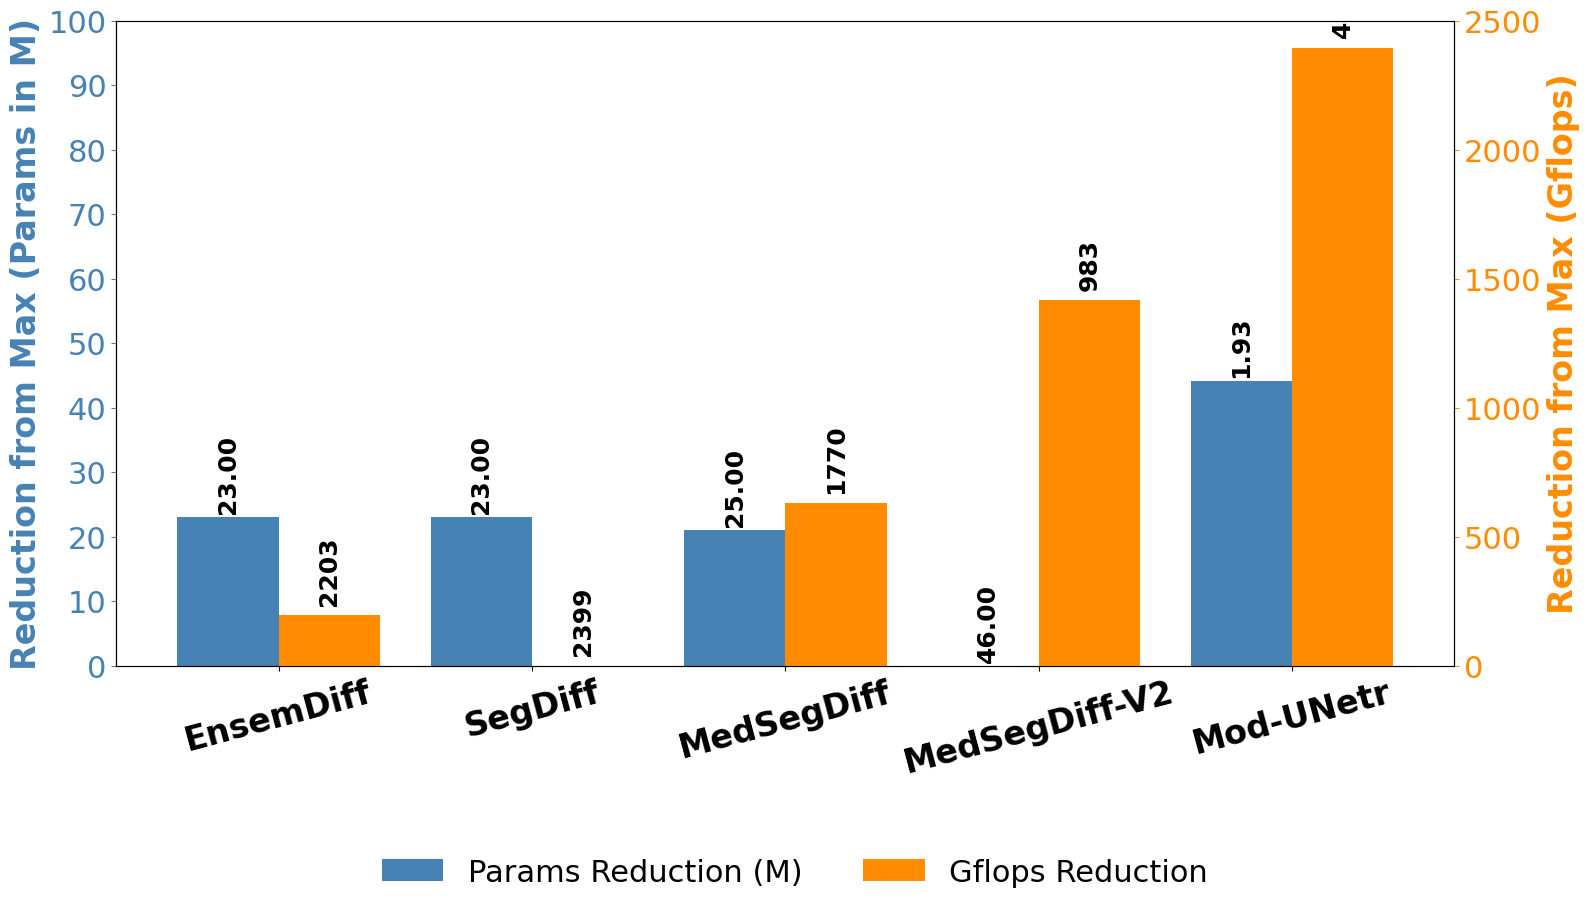

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['EnsemDiff', 'SegDiff', 'MedSegDiff', 'MedSegDiff-V2', 'Mod-UNetr']
params = [23, 23, 25, 46, 1.93]
gflops = [2203, 2399, 1770, 983, 3.73]

x = np.arange(len(models))
width = 0.4  # Slightly wider bars

fig, ax1 = plt.subplots(figsize=(16, 8))  # Wider figure

# Params Reduction (max - params)
param_reduction = [max(params) - p for p in params]
bars1 = ax1.bar(x - width/2, param_reduction, width, label='Params Reduction (M)', color='steelblue')

# Show actual param values on top of bars, rotated 90°, smaller font, slight offset up
for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.6,
             f'{params[i]:.2f}', ha='center', va='bottom', fontsize=18, fontweight='bold', rotation=90)

# Gflops Reduction (max - gflops)
gflops_reduction = [max(gflops) - g for g in gflops]
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, gflops_reduction, width, label='Gflops Reduction', color='darkorange')

# Show actual gflops values on top, rotated 90°, smaller font, slight offset up
for i, bar in enumerate(bars2):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 40,
             f'{gflops[i]:.0f}', ha='center', va='bottom', fontsize=18, fontweight='bold', rotation=90)

# Set y-axis limits and ticks explicitly
ax1.set_ylim(0, 100)
ax1.set_yticks([0, 10, 20, 30,40,50,60,70,80,90,100])
ax1.set_ylabel('Reduction from Max (Params in M)', fontsize=24, fontweight='bold', color='steelblue')
ax1.tick_params(axis='y', labelsize=22, colors='steelblue')

ax2.set_ylim(0, 2500)
ax2.set_yticks([0, 500, 1000, 1500, 2000, 2500])
ax2.set_ylabel('Reduction from Max (Gflops)', fontsize=24, fontweight='bold', color='darkorange')
ax2.tick_params(axis='y', labelsize=22, colors='darkorange')

# X-axis labels, less rotated for better spacing
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=24, fontweight='bold', rotation=15)

# Title


# Legend below
fig.legend(['Params Reduction (M)', 'Gflops Reduction'], loc='lower center', bbox_to_anchor=(0.5, -0.15),
           fontsize=22, ncol=2, frameon=False)

plt.tight_layout()
plt.show()
